### Wyznaczenie najlepszej kombinacji parametrów: rozmiaru słownika inicjalizującego, metody inicjalizacji, funkcji kosztu (dla metody inicjalizacji greedy), embeddingów oraz powtórzenie wyników Artetxe

#### Zmienne środowiskowe + ustawienia wyświetlania
<style>
table.dataframe {
    font-size:8pt;  
}
</style>

In [46]:
from matplotlib import rcParams
OUTPUT_PATH = '../output/'
INITIALIZATION = 'initializations/'
LEARNING = 'learning/'
from IPython.display import display
import pandas as pd

pd.set_option('display.max_colwidth', -1)      
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

rc = {'text.color':'white','axes.labelcolor':'white', 'xtick.color':'white','ytick.color':'white'}
sns.set_style("darkgrid",rc=rc)
True



True

#### Wczytanie danych

In [47]:
from glob import glob
df = pd.DataFrame()

for file_path in glob(OUTPUT_PATH+'results/*'):
    temp_df = pd.read_csv(file_path)
    df = pd.concat([df,temp_df], ignore_index=True)

df = df.sort_values('final_accuracy', ascending=False)
df['languages'] = df['source'] + '-' +  df['target']
df['cost'] = df['cost'] + ' ' + df['cost_threshold'].astype(str)
df['init'] = df['init'] + ' ' + df['cost']
df.loc[df['init']=='classic classic 100.0','init'] = 'classic'
df = df.drop(['source','target','words_learn','reverse','knn','init_only','init_time'],axis=1)
df = df.drop(['dropout_wait','cost_threshold','output','validation','keep_probability'],axis=1)
clean_df = df
df.head(5)

cost embedding  embedding_size  final_accuracy  final_objective  \
22   classic 100.0  word2vec  10000           0.722917        0.533467          
54   classic 100.0  fasttext  200000          0.670541        0.540951          
100  classic 100.0  fasttext  200000          0.665647        0.540439          
50   classic 100.0  fasttext  200000          0.665341        0.538987          
98   classic 100.0  fasttext  200000          0.665035        0.540641          

     final_similarity                  init  initialization_accuracy  \
22   0.367968          classic               0.002431                  
54   0.392836          greedy classic 100.0  0.001224                  
100  0.391886          classic               0.001224                  
50   0.392086          classic               0.001835                  
98   0.390924          greedy classic 100.0  0.001224                  

     initialization_cost_curve  initialization_cost_function  \
22   False                      53.477077                      
54   True                       61.790318                      
100  False                      89.113620                      
50   False                      64.446304                      
98   True                       88.629450                      

     initialization_objective  initialization_similarity  learning_time  \
22   0.263117                  0.059163                   1189.865959     
54   0.277468                  0.099460                   2223.648382     
100  0.287795                  0.111267                   2637.975565     
50   0.283586                  0.100904                   2676.226723     
98   0.282997                  0.108868                   2577.571654     

                                                                         name  \
22   en_es_ccla_c100_d50_ewor_e100_icla_iFal_i360_k01_k10_rFal_w200_w100_0702   
54   en_es_ccla_c100_efas_e200_igre_iFal_i360_k01_rFal_sen_tes_vdat_w200_8628   
100  en_es_ccla_c100_efas_e200_icla_iFal_i360_k01_rFal_sen_tes_vdat_w400_5702   
50   en_es_ccla_c100_efas_e200_icla_iFal_i360_k01_rFal_sen_tes_vdat_w200_3675   
98   en_es_ccla_c100_efas_e200_igre_iFal_i360_k01_rFal_sen_tes_vdat_w400_5576   

     words_initialize languages  
22   2000              en-es     
54   2000              en-es     
100  4000              en-es     
50   2000              en-es     
98   4000              en-es

In [48]:
df.describe()

embedding_size  final_accuracy  final_objective  final_similarity  \
count  123.000000      123.000000      123.000000       123.000000         
mean   195365.853659   0.292878        0.482306         0.213763           
std    29428.788262    0.285063        0.051491         0.143825           
min    10000.000000    0.000000        0.276787         0.021032           
25%    200000.000000   0.000602        0.444809         0.064809           
50%    200000.000000   0.420588        0.470621         0.271165           
75%    200000.000000   0.641907        0.539550         0.344809           
max    200000.000000   0.722917        0.552107         0.394227           

       initialization_accuracy  initialization_cost_function  \
count  123.000000               123.000000                     
mean   0.000721                 64.576094                      
std    0.000622                 34.001878                      
min    0.000000                 17.510687                      
25%    0.000226                 35.352383                      
50%    0.000593                 55.921013                      
75%    0.001185                 88.277910                      
max    0.002431                 136.847720                     

       initialization_objective  initialization_similarity  learning_time  \
count  123.000000                123.000000                 123.000000      
mean   0.265723                  0.065932                   2189.844468     
std    0.022147                  0.021856                   693.226042      
min    0.071970                  0.009982                   689.841701      
25%    0.257165                  0.050332                   1697.679572     
50%    0.266625                  0.065972                   2250.117783     
75%    0.274680                  0.081386                   2661.395879     
max    0.308917                  0.116915                   4851.917632     

       words_initialize  
count  123.000000        
mean   4617.886179       
std    2497.606478       
min    2000.000000       
25%    2000.000000       
50%    4000.000000       
75%    8000.000000       
max    8000.000000

In [49]:
df.groupby(['languages']).agg({'final_accuracy':['max','mean','std']})

final_accuracy                    
                     max      mean       std
languages                                   
en-de      0.645494       0.296908  0.314646
en-es      0.722917       0.431393  0.316023
en-fi      0.440459       0.153718  0.209519
pl-en      0.475340       0.284896  0.220746

Strasznie niskie accurac dla finskiego + duże rozrzuty, coś musi mocno zaniżać wyniki. Może, któraś inicjalizacja


In [50]:
df.groupby(['languages','init']).agg({'final_accuracy':['max','mean','std']})
# greedy wyglada ubogo, sprwadzmy czy dla obu funkcji kosztu


final_accuracy                    
                                                 max      mean       std
languages init                                                          
en-de     classic                      0.645494       0.322278  0.352012
          greedy classic 100.0         0.645494       0.324297  0.350281
          greedy quantity 10.0         0.645181       0.257662  0.315663
          greedy-random classic 100.0  0.643304       0.216536  0.330351
          greedy-random quantity 10.0  0.643617       0.363769  0.319676
en-es     classic                      0.722917       0.663633  0.028528
          greedy classic 100.0         0.670541       0.547900  0.268087
          greedy quantity 10.0         0.663506       0.436195  0.336581
          greedy-random classic 100.0  0.644741       0.278128  0.341688
          greedy-random quantity 10.0  0.663812       0.217947  0.337016
en-fi     classic                      0.436155       0.214442  0.233493
          greedy classic 100.0         0.435079       0.217262  0.237560
          greedy quantity 10.0         0.440459       0.145128  0.222167
          greedy-random classic 100.0  0.435796       0.143845  0.221730
          greedy-random quantity 10.0  0.438666       0.073304  0.178990
          qap classic 100.0            0.001382       0.001382 NaN      
pl-en     classic                      0.474225       0.449185  0.026412
          greedy classic 100.0         0.475340       0.447859  0.028908
          greedy quantity 10.0         0.473332       0.298766  0.232008
          greedy-random classic 100.0  0.473332       0.228331  0.248535
          greedy-random quantity 10.0  0.001131       0.000338  0.000424

Dla pl-en i en-es classic z bardzo małym odchyleniem.

Pierwszy wniosek -> sprawdzić greedy, drugi -> czemu dla 2 jest super a dla 2 nie? sprawdzić inicjalizacje, embeddingi

Greedy:


Wyniki zaniżone przez drugi sposób wyliczania kosztu. Odfiltrowanie uczeń z gorszym kosztem i ponowne porównanie inicjalizacji:

In [65]:
display(df.groupby(['languages','init']).agg({'final_accuracy':['max','mean','std']}))
display(df[(df.languages=='en-de') & (df.init=='classic')])
display(df[(df.languages=='en-es') & (df.init=='classic')])

final_accuracy                    
                                                 max      mean       std
languages init                                                          
en-de     classic                      0.645494       0.322278  0.352012
          greedy classic 100.0         0.645494       0.324297  0.350281
          greedy quantity 10.0         0.645181       0.257662  0.315663
          greedy-random classic 100.0  0.643304       0.216536  0.330351
          greedy-random quantity 10.0  0.643617       0.363769  0.319676
en-es     classic                      0.722917       0.663633  0.028528
          greedy classic 100.0         0.670541       0.547900  0.268087
          greedy quantity 10.0         0.663506       0.436195  0.336581
          greedy-random classic 100.0  0.644741       0.278128  0.341688
          greedy-random quantity 10.0  0.663812       0.217947  0.337016
en-fi     classic                      0.436155       0.214442  0.233493
          greedy classic 100.0         0.435079       0.217262  0.237560
          greedy quantity 10.0         0.440459       0.145128  0.222167
          greedy-random classic 100.0  0.435796       0.143845  0.221730
          greedy-random quantity 10.0  0.438666       0.073304  0.178990
          qap classic 100.0            0.001382       0.001382 NaN      
pl-en     classic                      0.474225       0.449185  0.026412
          greedy classic 100.0         0.475340       0.447859  0.028908
          greedy quantity 10.0         0.473332       0.298766  0.232008
          greedy-random classic 100.0  0.473332       0.228331  0.248535
          greedy-random quantity 10.0  0.001131       0.000338  0.000424

cost embedding  embedding_size  final_accuracy  final_objective  \
76  classic 100.0  word2vec  200000          0.645494        0.551939          
21  classic 100.0  word2vec  200000          0.643617        0.551954          
32  classic 100.0  word2vec  200000          0.641740        0.552107          
48  classic 100.0  fasttext  200000          0.001207        0.454805          
35  classic 100.0  fasttext  200000          0.000805        0.453684          
25  classic 100.0  fasttext  200000          0.000805        0.453214          

    final_similarity     init  initialization_accuracy  \
76  0.384715          classic  0.001564                  
21  0.384562          classic  0.001564                  
32  0.384530          classic  0.001252                  
48  0.074390          classic  0.000402                  
35  0.084868          classic  0.000000                  
25  0.071653          classic  0.000402                  

    initialization_cost_curve  initialization_cost_function  \
76  False                      126.816850                     
21  False                      90.256676                      
32  False                      64.305824                      
48  False                      59.039230                      
35  False                      125.528690                     
25  False                      84.116640                      

    initialization_objective  initialization_similarity  learning_time  \
76  0.273786                  0.093138                   813.144807      
21  0.270125                  0.090608                   1008.424797     
32  0.268479                  0.080657                   689.841701      
48  0.290356                  0.071747                   1639.715481     
35  0.308917                  0.094534                   1679.557372     
25  0.300355                  0.082777                   1562.157563     

                                                                        name  \
76  en_de_ccla_c100_ewor_e200_icla_iFal_i360_k01_rFal_sen_tde_vdat_w800_3475   
21  en_de_ccla_c100_ewor_e200_icla_iFal_i360_k01_rFal_sen_tde_vdat_w400_1967   
32  en_de_ccla_c100_ewor_e200_icla_iFal_i360_k01_rFal_sen_tde_vdat_w200_2533   
48  en_de_ccla_c100_efas_e200_icla_iFal_i360_k01_rFal_sen_tde_vdat_w200_2598   
35  en_de_ccla_c100_efas_e200_icla_iFal_i360_k01_rFal_sen_tde_vdat_w800_1685   
25  en_de_ccla_c100_efas_e200_icla_iFal_i360_k01_rFal_sen_tde_vdat_w400_9849   

    words_initialize languages  
76  8000              en-de     
21  4000              en-de     
32  2000              en-de     
48  2000              en-de     
35  8000              en-de     
25  4000              en-de

cost embedding  embedding_size  final_accuracy  final_objective  \
22   classic 100.0  word2vec  10000           0.722917        0.533467          
100  classic 100.0  fasttext  200000          0.665647        0.540439          
50   classic 100.0  fasttext  200000          0.665341        0.538987          
112  classic 100.0  fasttext  200000          0.664117        0.540433          
60   classic 100.0  word2vec  200000          0.644741        0.511048          
75   classic 100.0  word2vec  200000          0.643556        0.510946          
93   classic 100.0  word2vec  200000          0.639111        0.509874          

     final_similarity     init  initialization_accuracy  \
22   0.367968          classic  0.002431                  
100  0.391886          classic  0.001224                  
50   0.392086          classic  0.001835                  
112  0.392079          classic  0.001530                  
60   0.342562          classic  0.001778                  
75   0.343431          classic  0.000889                  
93   0.340774          classic  0.002074                  

     initialization_cost_curve  initialization_cost_function  \
22   False                      53.477077                      
100  False                      89.113620                      
50   False                      64.446304                      
112  False                      136.215130                     
60   False                      88.514590                      
75   False                      136.847720                     
93   False                      55.806940                      

     initialization_objective  initialization_similarity  learning_time  \
22   0.263117                  0.059163                   1189.865959     
100  0.287795                  0.111267                   2637.975565     
50   0.283586                  0.100904                   2676.226723     
112  0.292644                  0.116915                   1599.408463     
60   0.273210                  0.092092                   1730.644739     
75   0.277398                  0.101615                   2093.452867     
93   0.267731                  0.076374                   2932.894925     

                                                                         name  \
22   en_es_ccla_c100_d50_ewor_e100_icla_iFal_i360_k01_k10_rFal_w200_w100_0702   
100  en_es_ccla_c100_efas_e200_icla_iFal_i360_k01_rFal_sen_tes_vdat_w400_5702   
50   en_es_ccla_c100_efas_e200_icla_iFal_i360_k01_rFal_sen_tes_vdat_w200_3675   
112  en_es_ccla_c100_efas_e200_icla_iFal_i360_k01_rFal_sen_tes_vdat_w800_1656   
60   en_es_ccla_c100_ewor_e200_icla_iFal_i360_k01_rFal_sen_tes_vdat_w400_0895   
75   en_es_ccla_c100_ewor_e200_icla_iFal_i360_k01_rFal_sen_tes_vdat_w800_7936   
93   en_es_ccla_c100_ewor_e200_icla_iFal_i360_k01_rFal_sen_tes_vdat_w200_1668   

     words_initialize languages  
22   2000              en-es     
100  4000              en-es     
50   2000              en-es     
112  8000              en-es     
60   4000              en-es     
75   8000              en-es     
93   2000              en-es

Z tego wynika, że czasami fasttext nie zadziałał dobrze, możliwe że jakiś bład w ustawieniach

Porównanie embeddingów:

In [53]:
df.groupby(['languages','embedding']).agg({'final_accuracy':['max']})


final_accuracy
                               max
languages embedding               
en-de     fasttext   0.012068     
          word2vec   0.645494     
en-es     fasttext   0.670541     
          word2vec   0.722917     
en-fi     fasttext   0.002005     
          word2vec   0.436155     
pl-en     fasttext   0.475340     
          word2vec   0.426697

Możliwe, że coś zostało źle ustawione dla fasttexta en-es

Rozmiar słownika inicjalizującego:

In [54]:
df.groupby(['words_initialize']).agg({'final_accuracy':['max','mean','std']})

final_accuracy                    
                            max      mean       std
words_initialize                                   
2000              0.722917       0.355832  0.278883
4000              0.665647       0.350559  0.279641
8000              0.664117       0.302071  0.291645


********************************************************************

In [68]:
df=clean_df
# df = df[(df['cost']=='quantity 10.0') | (df['init']=='classic')] # w tym momencie koszt jest zawsze classic, olać
df.groupby(['embedding','words_initialize','languages','init']).agg({'final_accuracy':['max'],'initialization_accuracy':['max']})


final_accuracy  \
                                                                            max   
embedding words_initialize languages init                                         
fasttext  2000             en-de     classic                      0.001207        
                                     greedy classic 100.0         0.001207        
                                     greedy quantity 10.0         0.000000        
                                     greedy-random classic 100.0  0.000000        
                                     greedy-random quantity 10.0  0.000402        
                           en-es     classic                      0.665341        
                                     greedy classic 100.0         0.670541        
                                     greedy quantity 10.0         0.003059        
                                     greedy-random classic 100.0  0.000612        
                                     greedy-random quantity 10.0  0.663812        
                           en-fi     classic                      0.001203        
                                     greedy classic 100.0         0.000401        
                                     greedy quantity 10.0         0.000401        
                                     greedy-random classic 100.0  0.000000        
                                     greedy-random quantity 10.0  0.000401        
                           pl-en     classic                      0.474225        
                                     greedy classic 100.0         0.473109        
                                     greedy quantity 10.0         0.000223        
                                     greedy-random classic 100.0  0.473332        
                                     greedy-random quantity 10.0  0.000223        
          4000             en-de     classic                      0.000805        
                                     greedy classic 100.0         0.000402        
                                     greedy quantity 10.0         0.255430        
                                     greedy-random classic 100.0  0.003218        
                                     greedy-random quantity 10.0  0.252615        
                           en-es     classic                      0.665647        
                                     greedy classic 100.0         0.665035        
                                     greedy quantity 10.0         0.663200        
                                     greedy-random classic 100.0  0.015907        
                                     greedy-random quantity 10.0  0.000306        
                           en-fi     classic                      0.000802        
                                     greedy classic 100.0         0.000802        
                                     greedy quantity 10.0         0.000000        
                                     greedy-random classic 100.0  0.000000        
                                     greedy-random quantity 10.0  0.000401        
                           pl-en     classic                      0.472439        
                                     greedy classic 100.0         0.474225        
                                     greedy quantity 10.0         0.473332        
                                     greedy-random classic 100.0  0.471993        
                                     greedy-random quantity 10.0  0.000000        
          8000             en-de     classic                      0.000805        
                                     greedy classic 100.0         0.012068        
                                     greedy quantity 10.0         0.000805        
                                     greedy-random classic 100.0  0.000000        
                                     greedy-random quantity 10.0  0.000000        
                           en-es     classic                      0.664117       

Słownik początkowy: Co ciekawe dla fasttexta dla 2k nie było gorzej, a dla word2vec było. W ogólności nie widać różnicy
4 a 8k 

Embeddingi: Tam gdzie fasttext zadziałał zadziałał lepiej, pytanie co z tymi miejscami gdzie nie zadziałał wcale

Inicjalizacja: Okrojona funkcja kosztu daje szanse na przyspieszenie ale wyniki znacząco gorsze, samo użycie local searcha
nie wiem czy coś dało

Gdzie nie zadziałał fasttext:

In [56]:
df = clean_df[clean_df.embedding == 'fasttext']    
df[['final_accuracy','languages','init','cost','words_initialize']].tail(20)

final_accuracy languages                         init           cost  \
8    0.000401        en-fi     greedy quantity 10.0         quantity 10.0   
66   0.000401        en-fi     greedy-random quantity 10.0  quantity 10.0   
118  0.000306        en-es     greedy-random quantity 10.0  quantity 10.0   
40   0.000306        en-es     greedy-random classic 100.0  classic 100.0   
61   0.000306        en-es     greedy-random quantity 10.0  quantity 10.0   
102  0.000223        pl-en     greedy-random quantity 10.0  quantity 10.0   
69   0.000223        pl-en     greedy quantity 10.0         quantity 10.0   
78   0.000223        pl-en     greedy-random quantity 10.0  quantity 10.0   
52   0.000000        en-fi     greedy classic 100.0         classic 100.0   
11   0.000000        en-fi     greedy-random classic 100.0  classic 100.0   
119  0.000000        en-es     greedy-random classic 100.0  classic 100.0   
71   0.000000        en-de     greedy-random quantity 10.0  quantity 10.0   
15   0.000000        en-de     greedy quantity 10.0         quantity 10.0   
58   0.000000        en-fi     greedy-random classic 100.0  classic 100.0   
23   0.000000        en-de     greedy-random classic 100.0  classic 100.0   
99   0.000000        en-fi     greedy-random quantity 10.0  quantity 10.0   
30   0.000000        en-fi     greedy quantity 10.0         quantity 10.0   
67   0.000000        en-de     greedy-random classic 100.0  classic 100.0   
43   0.000000        pl-en     greedy-random quantity 10.0  quantity 10.0   
42   0.000000        pl-en     greedy-random classic 100.0  classic 100.0   

     words_initialize  
8    2000              
66   2000              
118  8000              
40   8000              
61   4000              
102  2000              
69   2000              
78   8000              
52   8000              
11   4000              
119  4000              
71   8000              
15   2000              
58   2000              
23   8000              
99   8000              
30   4000              
67   2000              
43   4000              
42   8000

In [57]:
clean_df[clean_df.embedding == 'word2vec'].tail(6)   


cost embedding  embedding_size  final_accuracy  final_objective  \
86   quantity 10.0  word2vec  200000          0.000452        0.404854          
44   quantity 10.0  word2vec  200000          0.000359        0.429632          
29   quantity 10.0  word2vec  200000          0.000313        0.419015          
7    quantity 10.0  word2vec  200000          0.000296        0.418451          
96   quantity 10.0  word2vec  200000          0.000000        0.403279          
116  quantity 10.0  word2vec  200000          0.000000        0.429579          

     final_similarity                         init  initialization_accuracy  \
86   0.048461          greedy-random quantity 10.0  0.000226                  
44   0.057787          greedy-random quantity 10.0  0.000000                  
29   0.036381          greedy quantity 10.0         0.000313                  
7    0.056200          greedy-random quantity 10.0  0.000296                  
96   0.031931          greedy-random quantity 10.0  0.000226                  
116  0.048534          greedy-random quantity 10.0  0.000000                  

     initialization_cost_curve  initialization_cost_function  \
86   True                       20.354284                      
44   True                       30.902578                      
29   True                       25.454205                      
7    True                       51.077610                      
96   True                       52.989530                      
116  True                       49.949540                      

     initialization_objective  initialization_similarity  learning_time  \
86   0.257199                  0.035255                   2581.966025     
44   0.249064                  0.035930                   2250.117783     
29   0.252988                  0.026250                   1487.121484     
7    0.252245                  0.055823                   2413.904795     
96   0.246953                  0.031816                   3102.708103     
116  0.243176                  0.032389                   2567.831149     

                                                                         name  \
86   pl_en_cqua_c100_ewor_e200_igre_iFal_i360_k01_rTru_spl_ten_vdat_w200_4414   
44   en_fi_cqua_c100_ewor_e200_igre_iFal_i360_k01_rFal_sen_tfi_vdat_w400_2093   
29   en_de_cqua_c100_ewor_e200_igre_iFal_i360_k01_rFal_sen_tde_vdat_w200_5858   
7    en_es_cqua_c100_ewor_e200_igre_iFal_i360_k01_rFal_sen_tes_vdat_w800_8886   
96   pl_en_cqua_c100_ewor_e200_igre_iFal_i360_k01_rTru_spl_ten_vdat_w800_5242   
116  en_fi_cqua_c100_ewor_e200_igre_iFal_i360_k01_rFal_sen_tfi_vdat_w800_8825   

     words_initialize languages  
86   2000              pl-en     
44   4000              en-fi     
29   2000              en-de     
7    8000              en-es     
96   8000              pl-en     
116  8000              en-fi

Cieżko było coś zauważyć, ale sprawdziłem dla word2vec i te z inicjalizacją local searchem wychodziły gorzej.


In [58]:
df = clean_df[clean_df.init == 'classic']
df = df[['final_accuracy','languages','embedding','words_initialize']]
df

final_accuracy languages embedding  words_initialize
22   0.722917        en-es     word2vec  2000            
100  0.665647        en-es     fasttext  4000            
50   0.665341        en-es     fasttext  2000            
112  0.664117        en-es     fasttext  8000            
76   0.645494        en-de     word2vec  8000            
60   0.644741        en-es     word2vec  4000            
21   0.643617        en-de     word2vec  4000            
75   0.643556        en-es     word2vec  8000            
32   0.641740        en-de     word2vec  2000            
93   0.639111        en-es     word2vec  2000            
121  0.474225        pl-en     fasttext  2000            
91   0.473109        pl-en     fasttext  8000            
39   0.472439        pl-en     fasttext  4000            
101  0.436155        en-fi     word2vec  8000            
53   0.426697        pl-en     word2vec  8000            
120  0.426018        pl-en     word2vec  4000            
97   0.423601        en-fi     word2vec  2000            
115  0.422884        en-fi     word2vec  4000            
55   0.422624        pl-en     word2vec  2000            
104  0.002005        en-fi     fasttext  8000            
48   0.001207        en-de     fasttext  2000            
27   0.001203        en-fi     fasttext  2000            
35   0.000805        en-de     fasttext  8000            
25   0.000805        en-de     fasttext  4000            
114  0.000802        en-fi     fasttext  4000

In [59]:
df.groupby(['languages','embedding']).agg({'final_accuracy':['max','mean','std']})


final_accuracy                    
                               max      mean       std
languages embedding                                   
en-de     fasttext   0.001207       0.000939  0.000232
          word2vec   0.645494       0.643617  0.001877
en-es     fasttext   0.665647       0.665035  0.000809
          word2vec   0.722917       0.662581  0.040297
en-fi     fasttext   0.002005       0.001337  0.000612
          word2vec   0.436155       0.427547  0.007464
pl-en     fasttext   0.474225       0.473257  0.000902
          word2vec   0.426697       0.425113  0.002182

In [67]:
df = clean_df
df = df[df.words_initialize==8000]
df.groupby(['embedding','languages','init']).agg({'initialization_accuracy':['max'],'initialization_cost_function':['max']})

initialization_accuracy  \
                                                                    max   
embedding languages init                                                  
fasttext  en-de     classic                      0.000000                 
                    greedy classic 100.0         0.000000                 
                    greedy quantity 10.0         0.000000                 
                    greedy-random classic 100.0  0.001207                 
                    greedy-random quantity 10.0  0.000402                 
          en-es     classic                      0.001530                 
                    greedy classic 100.0         0.001530                 
                    greedy quantity 10.0         0.001530                 
                    greedy-random classic 100.0  0.000000                 
                    greedy-random quantity 10.0  0.000306                 
          en-fi     classic                      0.000401                 
                    greedy classic 100.0         0.000401                 
                    greedy quantity 10.0         0.000401                 
                    greedy-random classic 100.0  0.000401                 
                    greedy-random quantity 10.0  0.000000                 
          pl-en     classic                      0.001116                 
                    greedy classic 100.0         0.000893                 
                    greedy quantity 10.0         0.000893                 
                    greedy-random classic 100.0  0.000000                 
                    greedy-random quantity 10.0  0.000223                 
word2vec  en-de     classic                      0.001564                 
                    greedy classic 100.0         0.000939                 
                    greedy quantity 10.0         0.000626                 
                    greedy-random classic 100.0  0.000626                 
                    greedy-random quantity 10.0  0.000313                 
          en-es     classic                      0.000889                 
                    greedy classic 100.0         0.001185                 
                    greedy quantity 10.0         0.000889                 
                    greedy-random classic 100.0  0.000000                 
                    greedy-random quantity 10.0  0.000296                 
          en-fi     classic                      0.001435                 
                    greedy classic 100.0         0.001435                 
                    greedy quantity 10.0         0.001435                 
                    greedy-random classic 100.0  0.000000                 
                    greedy-random quantity 10.0  0.000000                 
          pl-en     classic                      0.000000                 
                    greedy classic 100.0         0.000226                 
                    greedy quantity 10.0         0.000226                 
                    greedy-random classic 100.0  0.000452                 
                    greedy-random quantity 10.0  0.000226                 

                                                initialization_cost_function  
                                                                         max  
embedding languages init                                                      
fasttext  en-de     classic                      125.528690                   
                    greedy classic 100.0         125.276470                   
                    greedy quantity 10.0         41.909480                    
                    greedy-random classic 100.0  105.333180                   
                    greedy-random quantity 10.0  51.393375                    
          en-es     classic                      136.215130                   
                    greedy classic 100.0         136.103530                   
                    greedy quant

Obstawiam pomylone embeddingi w folderach


In [61]:
df = clean_df

df.groupby(['languages','embedding','init','cost','words_initialize']).agg({'final_accuracy':['max','mean','std']})



final_accuracy  \
                                                                                          max   
languages embedding init                        cost          words_initialize                  
en-de     fasttext  classic                     classic 100.0 2000              0.001207        
                                                              4000              0.000805        
                                                              8000              0.000805        
                    greedy classic 100.0        classic 100.0 2000              0.001207        
                                                              4000              0.000402        
                                                              8000              0.012068        
                    greedy quantity 10.0        quantity 10.0 2000              0.000000        
                                                              4000              0.255430        
                                                              8000              0.000805        
                    greedy-random classic 100.0 classic 100.0 2000              0.000000        
                                                              4000              0.003218        
                                                              8000              0.000000        
                    greedy-random quantity 10.0 quantity 10.0 2000              0.000402        
                                                              4000              0.252615        
                                                              8000              0.000000        
          word2vec  classic                     classic 100.0 2000              0.641740        
                                                              4000              0.643617        
                                                              8000              0.645494        
                    greedy classic 100.0        classic 100.0 2000              0.644243        
                                                              4000              0.642365        
                                                              8000              0.645494        
                    greedy quantity 10.0        quantity 10.0 2000              0.000313        
                                                              4000              0.645181        
                                                              8000              0.644243        
                    greedy-random classic 100.0 classic 100.0 2000              0.643304        
                                                              4000              0.642678        
                                                              8000              0.010013        
                    greedy-random quantity 10.0 quantity 10.0 2000              0.642678        
                                                              4000              0.643617        
                                                              8000              0.643304        
en-es     fasttext  classic                     classic 100.0 2000              0.665341        
                                                              4000              0.665647        
                                                              8000              0.664117        
                    greedy classic 100.0        classic 100.0 2000              0.670541        
                                                              4000              0.665035        
                                                              8000              0.664117        
                    greedy quantity 10.0        quantity 10.0 2000              0.003059        
                                                              4000              0.663200        
                                                              8000              0.663506        
     

In [62]:
t_df = clean_df[(clean_df.embedding == 'word2vec') & (clean_df.words_initialize == 4000) & (clean_df.init == 'classic')]
t_df = t_df.groupby(['languages']).agg({'final_accuracy':['max']}).reset_index()
print(t_df)
print()
w_df = pd.DataFrame.from_dict({'cos':5,'w':3},orient = 'index').reset_index()
w_df.columns = ['languages','final_accuracy']
print(w_df)

  languages final_accuracy
                       max
0  en-de     0.643617     
1  en-es     0.644741     
2  en-fi     0.422884     
3  pl-en     0.426018     

  languages  final_accuracy
0  cos       5             
1  w         3             


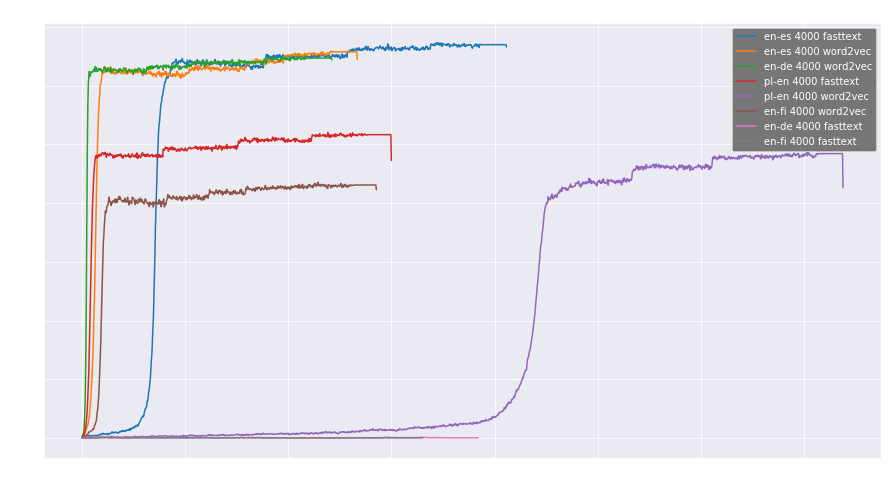

In [63]:
# By default, the plot aggregates over multiple y values at each value of x and shows an estimate of 
# the central tendency and a confidence interval for that estimate.
def source_target_initial_words_from_row(row):
    return f"{row['languages']} {row['words_initialize']}"

def source_target_initial_words_embedding_from_row(row):
    return f"{row['languages']} {row['words_initialize']} {row['embedding']}"

def line_plot_multiple_learning(df, get_y_from_df_function, get_name_from_row_function, title, xlabel, ylabel):
    output_df = pd.DataFrame({})
    for index, row in df.iterrows():
        learning_df_path = f"{OUTPUT_PATH}{LEARNING}{row['name']}.csv"
        learning_df = pd.read_csv(learning_df_path)
        learning_df.columns = learning_df.iloc[0]
        learning_df = learning_df[1:]
        
        y = get_y_from_df_function(learning_df)
        row_df = pd.DataFrame({get_name_from_row_function(row):y})
        output_df = pd.concat([output_df, row_df], axis=1)
        
    output_df=output_df.astype(float)
    
    plt.figure(figsize=(15,8))

    ax = sns.lineplot(data=output_df, dashes=False)
    
    legend = plt.legend()
    frame = legend.get_frame()
    frame.set_facecolor('0.35')
    
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title) 

df_with_curves = df[df['init']=='classic']
df_4k = df_with_curves[df_with_curves['words_initialize']==4000]
# df_4k = df_4k[df_4k['embedding']=='word2vec']
get_y_from_df = lambda d: d['Val_acc']

line_plot_multiple_learning(
    df_4k,
    get_y_from_df, 
    source_target_initial_words_embedding_from_row, 
    title='Super wykres',
    xlabel='Iteracja', 
    ylabel='Dokładność'
)
